In [2]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import torch
import time
from sklearn.datasets import make_sparse_spd_matrix
from scipy.spatial.distance import squareform
from sklearn.metrics import average_precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import utils_mcf

In [3]:
import rpy2.robjects.packages as rpackages
import anndata2ri

anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
def structure_error(true, pred, thresholding=False, eps=1e-2, no_diagonal=False):
    """
    + + + Code taken from https://github.com/fdtomasi/regain + + +
    
    Error in structure between a precision matrix and predicted.

    Parameters
    ----------
    true: array-like
        True matrix. In grpahical inference, if an entry is different from 0
        it is consider as an edge (inverse covariance).

    pred: array-like, shape=(d,d)
        Predicted matrix. In graphical inference, if an entry is different
        from 0 it is consider as an edge (inverse covariance).

    thresholding: bool, default False,
       Apply a threshold (with eps) to the `pred` matrix.

    eps : float, default = 1e-2
        Apply a threshold (with eps) to the `pred` matrix.

    """
    # avoid inplace modifications
    true = true.copy()
    pred = pred.copy()
    if true.ndim > 2:
        y_true = np.array(flatten([squareform(x, checks=None) for x in true]))
        y_pred = np.array(flatten([squareform(x, checks=None) for x in pred]))
    else:
        y_true = squareform(true, checks=None)
        y_pred = squareform(pred, checks=None)

    average_precision = average_precision_score(y_true > 0, y_pred)
    mcc = matthews_corrcoef(y_true > 0, y_pred > 0)

    if thresholding:
        pred[np.abs(pred) < eps] = 0
    tn_to_remove = 0
    if no_diagonal:
        if true.ndim > 2:
            true = np.array([t - np.diag(np.diag(t)) for t in true])
            pred = np.array([t - np.diag(np.diag(t)) for t in pred])
            tn_to_remove = np.prod(true.shape[:2])
        else:
            true -= np.diag(np.diag(true))
            pred -= np.diag(np.diag(pred))
            tn_to_remove = true.shape[0]
    true[true != 0] = 1
    pred[pred != 0] = 2
    res = true + pred
    # from collections import Counter
    # c = Counter(res.flat)
    # tn, fn, fp, tp = c[0], c[1], c[2], c[3]
    TN = np.count_nonzero((res == 0).astype(float)) - tn_to_remove
    FN = np.count_nonzero((res == 1).astype(float))
    FP = np.count_nonzero((res == 2).astype(float))
    TP = np.count_nonzero((res == 3).astype(float))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN)
    miss_rate = FN / (TP + FN) or 1 - recall
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    accuracy = (TP + TN) / true.size
    prevalence = (TP + FN) / true.size

    fall_out = FP / (FP + TN) if (FP + TN) > 0 else 1
    specificity = TN / (FP + TN) if (FP + TN) > 0 else 1.0 - fall_out

    balanced_accuracy = 0.5 * (recall + specificity)
    false_discovery_rate = FP / (TP + FP) if TP + FP > 0 else 1 - precision
    false_omission_rate = FN / (FN + TN) if FN + TN > 0 else 0
    negative_predicted_value = (
        TN / (FN + TN) if FN + TN > 0 else 1 - false_omission_rate
    )

    positive_likelihood_ratio = recall / fall_out if fall_out > 0 else 0
    negative_likelihood_ratio = miss_rate / specificity if specificity > 0 else 0
    diagnostic_odds_ratio = (
        positive_likelihood_ratio / negative_likelihood_ratio
        if negative_likelihood_ratio > 0
        else 0
    )

    dictionary = dict(
        tp=TP,
        tn=TN,
        fp=FP,
        fn=FN,
        precision=precision,
        recall=recall,
        f1=f1,
        accuracy=accuracy,
        false_omission_rate=false_omission_rate,
        fdr=false_discovery_rate,
        npv=negative_predicted_value,
        prevalence=prevalence,
        miss_rate=miss_rate,
        fall_out=fall_out,
        specificity=specificity,
        plr=positive_likelihood_ratio,
        nlr=negative_likelihood_ratio,
        dor=diagnostic_odds_ratio,
        balanced_accuracy=balanced_accuracy,
        average_precision=average_precision,
        mcc=mcc,
    )
    return dictionary


In [5]:
d = 30 # number of features
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # to generate 10 different ground truth precision matrices
n_samples = [10, 15, 20, 25, 30, 35, 40, 45 ,50]
p_values =  [0.1, 0.25, 0.5, 0.75, 1]
penalties = ['atan', 'selo', 'exp', 'log', 'sica', 'scad', 'mcp', 'adapt', 'lasso']
# some of the above algorithms (penalties) struggle in very low sample regimes,
# so we consider the minimal working number of samples for each method separately
left_outs = dict(zip(penalties, [0, 0, 2, 0, 0, 3, 4, 0, 0])) 

# generate 10 sparse precision matrices of dimendion d x d 
W_list, X_list = [], []
for seed in seeds:
    np.random.seed(seed)
    W = make_sparse_spd_matrix(d, alpha=0.9, random_state=2)
    cov = sp.linalg.inv(W)
    distr = sp.stats.multivariate_normal(mean=np.zeros(d), cov=cov)
    X = distr.rvs(100_000)
    W_list.append(W)
    X_list.append(X)

### Conditional Matrix Flows

In [8]:
# sample precision matrices through the proposed Conditional Matrix Flows
# here we load the trained models (which can be obtained by running 'main.py')
lamb_min_exp, lamb_max_exp = 0, 2
p_min, p_max = .1, 1.5
T0, Tn = 5, 1
epochs = 5001

cmf = []
for i_X, (X, seed) in enumerate(zip(X_list, seeds)):
    print('='*30, ' ', i_X, ' ', '='*30)
    flow_n_samples =[]
    for n in n_samples:
        print(n)
        X_ = X[:n]
        X_ /= X_.std(0)
        S = np.cov(X_, rowvar=False)
        S_torch = torch.from_numpy(S).float().cuda()
        file_name = f'd{d}_n{n}_e{epochs}_pmin{p_min}_pmax{p_max}_lmin{lamb_min_exp}_lmax{lamb_max_exp}_seed{seed}'
        folder_name = "./models_boxplots/"
        flow_state_dict = torch.load(f"{folder_name}/cmf_{file_name}"+f"_T1.000")
        flow = utils_mcf.build_positive_definite_vector(d, context_features=32, n_layers=3)
        flow.load_state_dict(flow_state_dict)
        flow.eval()

        f = open(f"{folder_name}/cmf_{file_name}.txt", "r") 
        alpha = float(f.read()) * n / 2
        log_alpha = np.log10(alpha) 

        p = torch.tensor(1.).cuda()
        flow_p_samples = []
        for p_value in p_values:
            flow_samples_, _, _, _, _, _, _, lambda_sorted = utils_mcf.sample_W_fixed_p(flow, S_torch, p=p*p_value, n=n, T=Tn, context_size=1, sample_size=5, lambda_min_exp=log_alpha, lambda_max_exp=log_alpha)
            flow_samples_ = flow_samples_.reshape(-1, d, d)
            flow_p_samples.append(flow_samples_)
        flow_n_samples.append(flow_p_samples)
    cmf.append(flow_n_samples)
np.save("cmf.npy", cmf)
del flow

==============================   0   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 140.64it/s]


15


100%|██████████| 200/200 [00:01<00:00, 136.79it/s]


20


100%|██████████| 200/200 [00:01<00:00, 116.74it/s]


25


100%|██████████| 200/200 [00:01<00:00, 139.31it/s]


30


100%|██████████| 200/200 [00:01<00:00, 148.90it/s]


35


100%|██████████| 200/200 [00:01<00:00, 145.50it/s]


40


100%|██████████| 200/200 [00:01<00:00, 155.34it/s]


45


100%|██████████| 200/200 [00:01<00:00, 154.97it/s]


50


100%|██████████| 200/200 [00:01<00:00, 155.84it/s]


==============================   1   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 152.64it/s]


15


100%|██████████| 200/200 [00:01<00:00, 155.95it/s]


20


100%|██████████| 200/200 [00:01<00:00, 149.18it/s]


25


100%|██████████| 200/200 [00:01<00:00, 152.03it/s]


30


100%|██████████| 200/200 [00:01<00:00, 154.10it/s]


35


100%|██████████| 200/200 [00:01<00:00, 156.36it/s]


40


100%|██████████| 200/200 [00:01<00:00, 154.16it/s]


45


100%|██████████| 200/200 [00:01<00:00, 157.02it/s]


50


100%|██████████| 200/200 [00:01<00:00, 156.51it/s]


==============================   2   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 156.12it/s]


15


100%|██████████| 200/200 [00:01<00:00, 150.42it/s]


20


100%|██████████| 200/200 [00:01<00:00, 156.80it/s]


25


100%|██████████| 200/200 [00:01<00:00, 140.99it/s]


30


100%|██████████| 200/200 [00:01<00:00, 151.65it/s]


35


100%|██████████| 200/200 [00:01<00:00, 152.55it/s]


40


100%|██████████| 200/200 [00:01<00:00, 150.03it/s]


45


100%|██████████| 200/200 [00:01<00:00, 151.61it/s]


50


100%|██████████| 200/200 [00:01<00:00, 149.11it/s]


==============================   3   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 149.92it/s]


15


100%|██████████| 200/200 [00:01<00:00, 155.20it/s]


20


100%|██████████| 200/200 [00:01<00:00, 155.52it/s]


25


100%|██████████| 200/200 [00:01<00:00, 153.20it/s]


30


100%|██████████| 200/200 [00:01<00:00, 153.77it/s]


35


100%|██████████| 200/200 [00:01<00:00, 150.95it/s]


40


100%|██████████| 200/200 [00:01<00:00, 154.61it/s]


45


100%|██████████| 200/200 [00:01<00:00, 135.06it/s]


50


100%|██████████| 200/200 [00:01<00:00, 147.84it/s]


==============================   4   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 154.21it/s]


15


100%|██████████| 200/200 [00:01<00:00, 154.87it/s]


20


100%|██████████| 200/200 [00:01<00:00, 146.81it/s]


25


100%|██████████| 200/200 [00:01<00:00, 151.87it/s]


30


100%|██████████| 200/200 [00:01<00:00, 154.63it/s]


35


100%|██████████| 200/200 [00:01<00:00, 155.67it/s]


40


100%|██████████| 200/200 [00:01<00:00, 156.17it/s]


45


100%|██████████| 200/200 [00:01<00:00, 154.79it/s]


50


100%|██████████| 200/200 [00:01<00:00, 152.07it/s]


==============================   5   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 155.85it/s]


15


100%|██████████| 200/200 [00:01<00:00, 154.65it/s]


20


100%|██████████| 200/200 [00:01<00:00, 155.74it/s]


25


100%|██████████| 200/200 [00:01<00:00, 155.34it/s]


30


100%|██████████| 200/200 [00:01<00:00, 145.76it/s]


35


100%|██████████| 200/200 [00:01<00:00, 150.32it/s]


40


100%|██████████| 200/200 [00:01<00:00, 145.35it/s]


45


100%|██████████| 200/200 [00:01<00:00, 155.36it/s]


50


100%|██████████| 200/200 [00:01<00:00, 156.61it/s]


==============================   6   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 156.51it/s]


15


100%|██████████| 200/200 [00:01<00:00, 153.19it/s]


20


100%|██████████| 200/200 [00:01<00:00, 148.45it/s]


25


100%|██████████| 200/200 [00:01<00:00, 147.20it/s]


30


100%|██████████| 200/200 [00:01<00:00, 148.16it/s]


35


100%|██████████| 200/200 [00:01<00:00, 146.71it/s]


40


100%|██████████| 200/200 [00:01<00:00, 149.18it/s]


45


100%|██████████| 200/200 [00:01<00:00, 140.54it/s]


50


100%|██████████| 200/200 [00:01<00:00, 144.46it/s]


==============================   7   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 151.58it/s]


15


100%|██████████| 200/200 [00:01<00:00, 149.77it/s]


20


100%|██████████| 200/200 [00:01<00:00, 146.25it/s]


25


100%|██████████| 200/200 [00:01<00:00, 148.18it/s]


30


100%|██████████| 200/200 [00:01<00:00, 150.49it/s]


35


100%|██████████| 200/200 [00:01<00:00, 147.54it/s]


40


100%|██████████| 200/200 [00:01<00:00, 140.53it/s]


45


100%|██████████| 200/200 [00:01<00:00, 148.08it/s]


50


100%|██████████| 200/200 [00:01<00:00, 156.20it/s]


==============================   8   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 149.55it/s]


15


100%|██████████| 200/200 [00:01<00:00, 153.26it/s]


20


100%|██████████| 200/200 [00:01<00:00, 144.19it/s]


25


100%|██████████| 200/200 [00:01<00:00, 151.30it/s]


30


100%|██████████| 200/200 [00:01<00:00, 150.14it/s]


35


100%|██████████| 200/200 [00:01<00:00, 148.76it/s]


40


100%|██████████| 200/200 [00:01<00:00, 152.93it/s]


45


100%|██████████| 200/200 [00:01<00:00, 153.31it/s]


50


100%|██████████| 200/200 [00:01<00:00, 154.84it/s]


==============================   9   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 143.87it/s]


15


100%|██████████| 200/200 [00:01<00:00, 153.05it/s]


20


100%|██████████| 200/200 [00:01<00:00, 133.72it/s]


25


100%|██████████| 200/200 [00:01<00:00, 136.91it/s]


30


100%|██████████| 200/200 [00:01<00:00, 143.21it/s]


35


100%|██████████| 200/200 [00:01<00:00, 153.62it/s]


40


100%|██████████| 200/200 [00:01<00:00, 150.12it/s]


45


100%|██████████| 200/200 [00:01<00:00, 151.03it/s]


50


100%|██████████| 200/200 [00:01<00:00, 155.05it/s]


### Bayesian Graphical Lasso

In [ ]:
# sample precision matrices with the Bayesian Graphical Lasso approach by Wang (2012)
BayesianGLasso = rpackages.importr('BayesianGLasso')

ones = np.ones((1000, d, d))
bayes_glasso_samples = []
start_time = time.time()
for n in n_samples:
    print('+'*40, ' ', n, ' ', '+'*40)
    precisions = []
    for X in X_list:
        X_ = X[:n]
        X_ /= X_.std(0)
        %R -i X_ -o BayesGLasso BayesGLasso <- blockGLasso(X=X_, iterations=4000, burnIn=1000, lambdaPriora=1, lambdaPriorb=.1)
        BayesGlasso_prec = [value for i, (key, value) in enumerate(BayesGLasso['Omegas'].items()) if i+1>1000 and (i+1)%4==0]
        precisions.append(np.array(BayesGlasso_prec))
        print("--- %s seconds ---" % (time.time() - start_time))
    np.save(f"bayes_glasso_samples_{n}.npy", np.array(precisions, dtype=object))
    bayes_glasso_samples.append(precisions)
bayes_glasso_samples = np.array(bayes_glasso_samples, dtype=object)
np.save("bayes_glasso_samples.npy", bayes_glasso_samples)

### Frequentist approach: GMMs with Nonconvex Regularization

Precision matrix reconstruction through two classes of penalties

- l0 approximations:  
    - Atan ("atan") by Wang and Zhu (2016) 
    - Seamless L0 ("selo") by Dicker et al. (2013)
    - Exponential ("exp") by Wang et al. (2018)
    - Log ("log") by Mazumder et al. (2011)
    - SICA ("sica") by Lv and Fan (2009)


- additional penalties(smooth interpolation between l0 and l1):
    - SCAD ("scad") by Fan and Li (2001)
    - MC+ ("mcp") by Zhang (2010)
    - Adaptive lasso ("adapt") by Zou (2006)

In [ ]:
# for more details see the R package 'GGMncv'
# through the proposed Conditional Matrix Flows
GGmncv = rpackages.importr('GGMncv')
penalties = ['atan', 'selo', 'exp', 'log', 'sica', 'scad', 'mcp', 'adapt', 'lasso']
ggmncv = {}
left_outs = dict(zip(penalties, [0,0,2,0,0,3,4,0,0]))
for penalty in penalties:
    print('='*30, ' ', penalty, ' ', '='*30)
    samples = []
    for n in n_samples[left_outs[penalty]:]:
        print('+'*20, ' ', n, ' ', '+'*20)
        precisions = []    
        for X in X_list:
            X_ = X[:n]
            X_ /= X_.std(0)
            S = np.corrcoef(X_, rowvar=False)
            %R -i S -i n -i d -i penalty -i X_ -o fit fit <- ggmncv(S, n=n, progress = FALSE, penalty=penalty, initial=ledoit_wolf, Y=X_)
            precisions.append(fit['Theta'])
        samples.append(precisions)
    ggmncv[penalty] = np.arrays(samples)
np.save("ggmncv.npy", ggmncv)

### Results comparison

In [9]:
#can choose from a variety of scores: e.g. 'f1', 'accuracy', 'precision' etc.
score = 'f1'

In [13]:
# credibility intervals
conf_bayes = 0.9
conf_flow = 0.9
glasso_scores = []

settings = dict(thresholding=False, eps=1e-2, no_diagonal=False)

print('computing scores for Conditional Matrix Flow...')
cmf = np.load('cmf.npy', allow_pickle=True)
cmf_scores = []
for i_p in range(len(p_values)):
    p_scores = []
    for i_n in range(len(n_samples)):
        n_scores = []
        for i_x, W in enumerate(W_list[:4]):
            n = n_samples[i_n]
            samples = cmf[i_x][i_n][i_p]
            qleft = np.quantile(samples, 0.5 - conf_flow*0.5, 0)
            qright = np.quantile(samples, 0.5 + conf_flow*0.5, 0)
            signif_edge = qleft * qright > 0
            signed_signif = np.sign(qleft) * signif_edge
            error = structure_error(W, signed_signif, **settings)[score]
            n_scores.append(error)
        p_scores.append(n_scores)
    cmf_scores.append(p_scores)
cmf_scores = np.array(cmf_scores)

print('computing scores for Bayesian Graphical Lasso...')
bayes_glasso_samples = np.load('bayes_glasso_samples.npy', allow_pickle=True)
bayes_glasso_scores = []
for i_n in range(len(n_samples[1::2])):
    n = n_samples[i_n]
    error = []
    for i_W, W in enumerate(W_list):
        samples = bayes_glasso_samples[i_n][i_W]
        qleft = np.quantile(samples, 0.5 - conf_bayes*0.5, 0)
        qright = np.quantile(samples, 0.5 + conf_bayes*0.5, 0)
        signif_edge = qleft * qright > 0
        signed_signif = np.sign(qleft) * signif_edge
        error_ = structure_error(W, signed_signif, **settings)[score]
        error.append(error_)
    bayes_glasso_scores.append(error)
bayes_glasso_scores = np.array(bayes_glasso_scores)
    
print('computing scores for GGMncv...')
ggmncv = np.load('ggmncv.npy', allow_pickle=True)[()]
ggmncv_scores = {}
for penalty in penalties:
    n_scores = []
    for i_n in range(len(n_samples[left_outs[penalty]:])):
        n = n_samples[i_n]
        error = [ structure_error(W, ggmncv[penalty][i_n][i_W], **settings)[score] for i_W, W in enumerate(W_list)]
        n_scores.append(error)
    ggmncv_scores[penalty] = np.array(n_scores)

computing scores for Conditional Matrix Flow...
computing scores for Bayesian Graphical Lasso...
computing scores for GGMncv...


In [15]:
# convert to dataframe to use sns.boxplots
df_cmf_dict = {}
for i_p, p_value in enumerate(p_values):
    df_cmf = pd.DataFrame(cmf_scores[i_p].T, columns=n_samples).assign(model=f"CMF ($p$={p_value})")
    df_cmf_dict[p_value] = df_cmf

df_bayes_glasso = pd.DataFrame(bayes_glasso_scores.T, columns = n_samples[1::2]).assign(model='BGL')

df_ggmncv_dict = {}
for penalty in penalties:
    df_ggmncv =pd.DataFrame(ggmncv_scores[penalty].T, columns = n_samples[left_outs[penalty]:]).assign(model=penalty)
    df_ggmncv_dict[penalty] = df_ggmncv

#### Conditional Matrix Flow vs frequentist GGMs with l0 approximation penalty

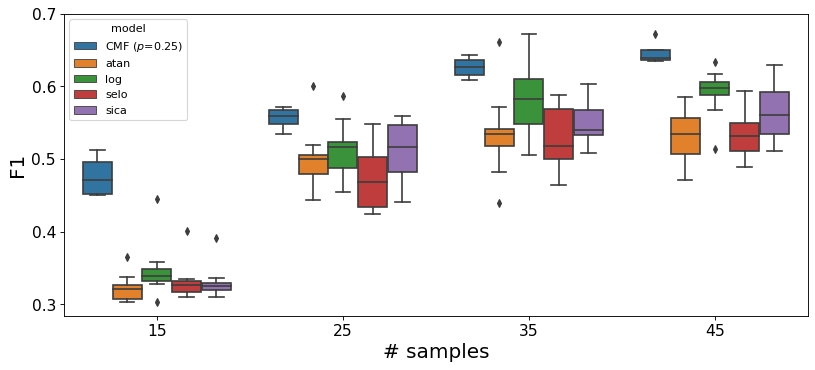

In [13]:
penalties = ['atan', 'selo', 'exp', 'log', 'sica', 'scad', 'mcp', 'adapt', 'lasso']
cdf = pd.concat([df_cmf_dict[p_values[1]], df_ggmncv_dict['atan'], df_ggmncv_dict['log'], df_ggmncv_dict['selo'], 
                 df_ggmncv_dict['sica']])#,  df_ggmncv_dict['exp']])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
plt.figure(figsize=(12, 5), dpi=80)
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
ax = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset)  # RUN PLOT
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=14)
plt.xlabel('# samples', fontsize=18)
plt.ylabel('F1', fontsize=18)
# plt.savefig(f"box_plot_{score}_flow_l0ncv.pdf", dpi=200,  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow (with p<1) vs Bayesian Graphical Lasso

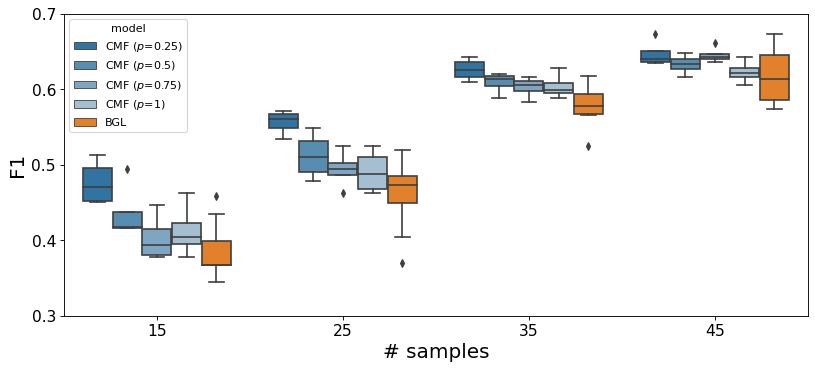

In [15]:
palette_tab10 = sns.color_palette("tab10", 10)
palette_blue = list(sns.light_palette(palette_tab10[0], n_colors=6))[::-1][:4]
palette_salmon = list(sns.light_palette(palette_tab10[1], n_colors=6))[::-1][:1]
palette = palette_blue + palette_salmon

cdf = pd.concat([df_cmf_dict[p_values[1]], df_cmf_dict[p_values[2]], 
                 df_cmf_dict[p_values[3]], df_cmf_dict[p_values[4]], df_bayes_glasso])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
plt.figure(figsize=(12, 5), dpi=80)
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
ax = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset, palette=palette)  # RUN PLOT
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=14)
plt.xlabel('# samples', fontsize=18)
plt.ylabel('F1', fontsize=18)
# plt.savefig(f"box_plot_{score}_flow_bayes_glasso.pdf", dpi=200,  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow (with p<1) vs SCAD, MC+ and Adaptive lasso (as a function of $\gamma$)

In [34]:
# select gamma for each method. We start from the minimal working gamma in each setting
gamma_dict = dict(scad= [3.5,4,5,10,100], 
                  mcp= [2,3,4,10,100],#,3.5,10,100]
                  adapt= [0.1,0.2,0.3,0.5,1])#,0.3,0.5,1])

In [ ]:
GGmncv = rpackages.importr('GGMncv')
ggmncv_gamma = {}
left_outs = dict(zip(penalties[-4:-1], [3,4,0]))
for penalty in penalties[-4:-1]:
    print('='*30, ' ', penalty, ' ', '='*30)
    gamma_list = {}
    for gamma in gamma_dict[penalty]:
        print('-'*20, ' ', gamma, ' ', '-'*20)
        sample_list = []
        for n in n_samples[left_outs[penalty]:]:
            print('+'*20, ' ', n, ' ', '+'*20)
            prec_list = []    
            for X in X_list:
                X_ = X[:n]
                X_ /= X_.std(0)
                S = np.corrcoef(X_, rowvar=False)
                %R -i S -i n -i d -i penalty -i X_ -i gamma -o fit fit <- ggmncv(S, n=n, progress = FALSE, penalty=penalty, initial=ledoit_wolf, Y=X_, gamma=gamma)
                prec_list.append(fit['Theta'])
            sample_list.append(prec_list)
        gamma_list[gamma] = np.array(sample_list)
    ggmncv_gamma[penalty] = gamma_list
np.save("ggmncv_gamma.npy", ggmncv_gamma)

In [41]:
print('computing scores for GGMncv gamma...')
ggmncv_gamma = np.load('ggmncv_gamma.npy', allow_pickle=True)[()]
ggmncv_gamma_score = {}
for penalty in penalties[-4:-1]:
    gamma_score = {}
    for gamma in gamma_dict[penalty]:
        n_scores = []
        for i_n in range(len(n_samples[left_outs[penalty]:])):
            n = n_samples[i_n]
            error = [ structure_error(W, ggmncv_gamma[penalty][gamma][i_n][i_W], 
                                      **settings)[score] for i_W, W in enumerate(W_list)]
            n_scores.append(error)
        gamma_score[gamma] = np.array(n_scores)
    ggmncv_gamma_score[penalty] = gamma_score

computing scores for GGMncv gamma...


#### Conditional Matrix Flow (with p<1) vs adaptive Lasso

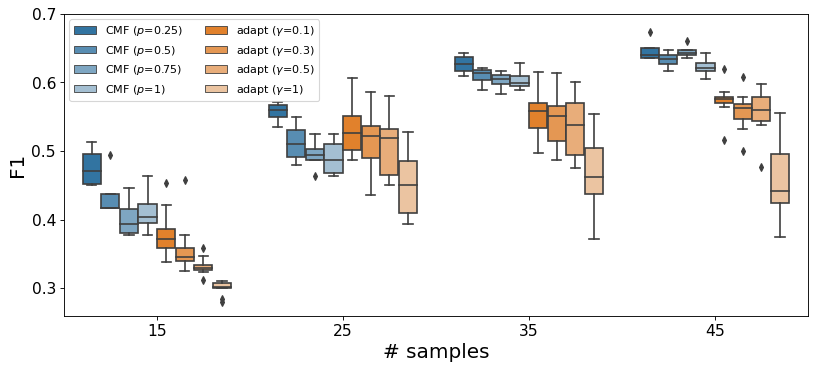

In [90]:
penalty = 'adapt'

palette_blue = list(sns.light_palette(palette_tab10[0], n_colors=6))[::-1][:4]
palette_salmon = list(sns.light_palette(palette_tab10[1], n_colors=6))[::-1][:4]
palette = palette_blue + palette_salmon

df_ggmncv_gamma_dict = {}
for gamma in gamma_dict[penalty]:
    df_ggmncv = pd.DataFrame(ggmncv_gamma_score[penalty][gamma].T, 
                            columns = n_samples[left_outs[penalty]:]).assign(model=f"{penalty} ($\gamma$={gamma})")
    df_ggmncv_gamma_dict[gamma] = df_ggmncv

cdf = pd.concat([df_cmf_dict[p_values[1]], df_cmf_dict[p_values[2]], 
                 df_cmf_dict[p_values[3]], df_cmf_dict[p_values[4]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][0]], df_ggmncv_gamma_dict[gamma_dict[penalty][2]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][3]], df_ggmncv_gamma_dict[gamma_dict[penalty][4]]])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
plt.figure(figsize=(12, 5), dpi=80)
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
ax = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset, palette=palette)
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=14)
plt.xlabel('# samples', fontsize=18)
plt.ylabel('F1', fontsize=18)
plt.legend(ncol=2, loc='lower center')
plt.legend(ncol=2, loc='upper left')
# plt.savefig(f"box_plot_{score}_flow_{penalty}_.pdf", dpi=200,  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow (with p<1) vs SCAD

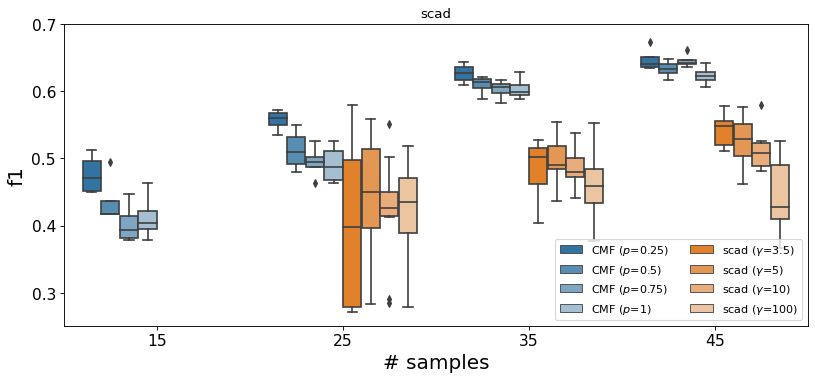

In [79]:
penalty = 'scad'

palette_blue = list(sns.light_palette(palette_tab10[0], n_colors=6))[::-1][:4]
palette_salmon = list(sns.light_palette(palette_tab10[1], n_colors=6))[::-1][:4]
palette = palette_blue + palette_salmon

df_ggmncv_gamma_dict = {}
for gamma in gamma_dict[penalty]:
    df_ggmncv = pd.DataFrame(ggmncv_gamma_score[penalty][gamma].T, 
                            columns = n_samples[left_outs[penalty]:]).assign(model=f"{penalty} ($\gamma$={gamma})")
    df_ggmncv_gamma_dict[gamma] = df_ggmncv

cdf = pd.concat([df_cmf_dict[p_values[1]], df_cmf_dict[p_values[2]], 
                 df_cmf_dict[p_values[3]], df_cmf_dict[p_values[4]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][0]], df_ggmncv_gamma_dict[gamma_dict[penalty][2]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][3]], df_ggmncv_gamma_dict[gamma_dict[penalty][4]]])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name='f1')
plt.figure(figsize=(12, 5), dpi=80)
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
ax = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset, palette=palette)
plt.title(penalty)
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=14)
plt.xlabel('# samples', fontsize=18)
plt.ylabel(score, fontsize=18)
plt.legend(ncol=2, loc='lower right')
# plt.savefig(f"box_plot_{score}_flow_{penalty}_.pdf", dpi=200,  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow (with p<1) vs MC+

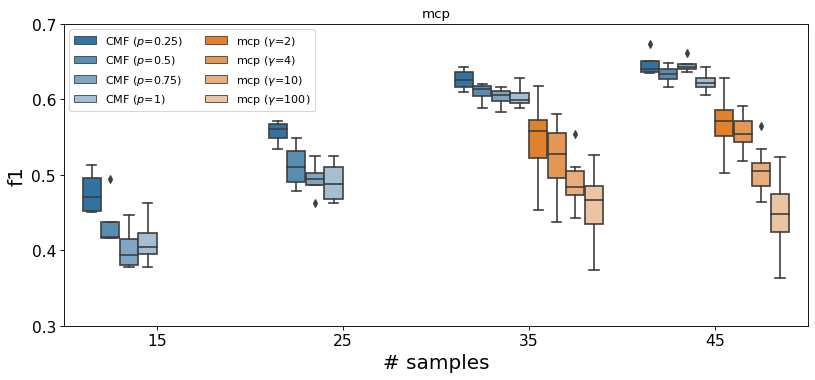

In [74]:
penalty = 'mcp'

palette_blue = list(sns.light_palette(palette_tab10[0], n_colors=6))[::-1][:4]
palette_salmon = list(sns.light_palette(palette_tab10[1], n_colors=6))[::-1][:4]
palette = palette_blue + palette_salmon

df_ggmncv_gamma_dict = {}
for gamma in gamma_dict[penalty]:
    df_ggmncv = pd.DataFrame(ggmncv_gamma_score[penalty][gamma].T, 
                            columns = n_samples[left_outs[penalty]:]).assign(model=f"{penalty} ($\gamma$={gamma})")
    df_ggmncv_gamma_dict[gamma] = df_ggmncv

cdf = pd.concat([df_cmf_dict[p_values[1]], df_cmf_dict[p_values[2]], 
                 df_cmf_dict[p_values[3]], df_cmf_dict[p_values[4]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][0]], df_ggmncv_gamma_dict[gamma_dict[penalty][2]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][3]], df_ggmncv_gamma_dict[gamma_dict[penalty][4]]])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
plt.figure(figsize=(12, 5), dpi=80)
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
ax = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset, palette=palette)
plt.title(penalty)
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=14)
plt.xlabel('# samples', fontsize=18)
plt.ylabel(score, fontsize=18)
plt.legend(ncol=2, loc='upper left')
# plt.savefig(f"box_plot_{score}_flow_{penalty}_.pdf", dpi=200,  bbox_inches='tight')
plt.show()